# SIRDモデル (ベースとなるコード)
SIRD (Susceptible, Infectious, Recovered, or Decreased)モデル: 感染症の拡大を予測する（伝統的な）SIR モデルに死亡 (Decreased or Death)を追加したモデル

### MAS の仕様
- 最初に，一定数のエージェントを「感染」状態とする
- エージェントは空間内をランダムに移動し，接触した（＝同じセルに属した）場合に感染するものとする
- 感染後，多くのエージェントは一定時間経過すると回復する。しかし，1% の確率で死亡する。

### コード

In [6]:
# 必要なクラスのインポート
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from enum import IntEnum

# 状態の定義
class State(IntEnum):
    SUSCEPTIBLE = 0 # 健康(影響を受けやすい)
    INFECTED = 1 # 感染した
    RECOVERED = 2 # 回復(耐性を有する)
    DECREASED = 3 # 死亡

class HumanAgent(Agent):
    # エージェントの初期化
    # unique_id : 個々のエージェントを区別するための ID（名前みたいなもの）
    # initial_state : 初期状態
    def __init__(self, unique_id, model, initial_state):
        super().__init__(unique_id, model)
        self.state = initial_state
        self.infection_time = -1 # 感染したタイミング

    def move(self):
        # Moore 近傍にて，移動可能な場所 (possible_steps)を探す
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True, # Moore 近傍
            include_center = False) # 中心を含まない
        
        # 移動先をランダムに決める
        new_position = self.random.choice(possible_steps)
        
        # 自分自身を new_position へ動かす
        self.model.grid.move_agent(self, new_position)
        
    def try_infection(self):
        # 自分の位置 (self.pos) と同じセルにいる他のエージェントを探す
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1: # 自分を含めてカウントするため，２以上のケースを考える
            for other in cellmates:
                # 自分自身が選ばれた場合，何もしない
                if other.unique_id == self.unique_id: continue
            
                # 相手が健常の場合，情け容赦なく感染させる
                if other.state == State.SUSCEPTIBLE or other.state == State.RECOVERED:
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time # 感染したタイミングを記録

    def step(self):
        if self.state == State.DECREASED:
            pass # 何もしない
        elif self.state == State.INFECTED:
            # 1% の確率で死亡する
            r_death = self.random.random()
            if r_death < 0.01:
                self.state = State.DECREASED
            else:
                self.move() # 移動
                
                # 生きている場合，一定時間経過後に RECOVERD へ or 他者へ感染させる
                # 感染後の経過時間
                t = self.model.schedule.time - self.infection_time

                # 感染後，一定時間(以下では 20ステップ)が経過すれば回復（免疫あり）の状態になる
                if t >= 20:
                    self.state = State.RECOVERED
                else:
                    self.try_infection()
            
class SRI_Model(Model):
    def __init__(self, N=100, width=30, height=30):
        self.num_human = N
        # ひとつのセルに複数のエージェントが存在してよいように MultiGrid とする
        self.grid = MultiGrid(width, height, torus=True)

        # スケジューラの設定
        self.schedule = RandomActivation(self)
        
        # エージェントの生成
        for i in range(self.num_human):
            a = HumanAgent(i, self, State.SUSCEPTIBLE) # 第２引数はモデル自身
            self.schedule.add(a) # エージェントのスケジュールへの追加
            
            # エージェントをランダムな位置に配置する
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
            # 空間の初期状態として，10% を「感染」状態とする
            r = self.random.random()
            if r < 0.1:
                a.state = State.INFECTED
                a.infection_time = 0
                
        # DataCollector の定義
        self.data_collector = DataCollector(
            agent_reporters={"State": "state"}
        )
        
    def step(self):
        self.data_collector.collect(self) # データ収集
        self.schedule.step()
        
model = SRI_Model(N=200, width=30, height=30)
for i in range(150): # 150ステップ
    model.step()

### 各ステップにおける健常者数・感染者数・回復者数をチェック

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
result = model.data_collector.get_agent_vars_dataframe()
X = pd.pivot_table(result.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)
labels = ['Susceptible','Infected','Recovered', 'Decreased']
X.columns = labels[:len(X.columns)]

In [8]:
X

,Susceptible,Infected,Recovered,Decreased
Step,,,,
0,178,22,0,0
1,177,23,0,0
2,173,27,0,0
3,169,31,0,0
4,167,33,0,0
...,...,...,...,...
145,0,31,76,93
146,0,33,74,93
147,0,34,73,93


### 感染状況の推移を可視化

<AxesSubplot:xlabel='Step'>

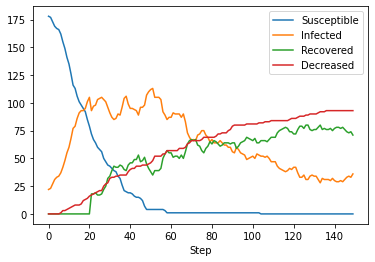

In [9]:
X.plot()